### Import Libraries

In [23]:
import os
import numpy as np
from scipy.io import loadmat
from PIL import Image
import cv2
import matplotlib.pyplot as plt 

### Dataset preparation

In [8]:
def mat_to_png(input_folder, output_folder):
    """
    Convert all .mat images in a folder to .png format and save them to an output folder.

    Parameters:
        input_folder (str): Path to the folder containing .mat files.
        output_folder (str): Path to the folder where .png files will be saved.
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Loop through all .mat files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".mat"):
            mat_path = os.path.join(input_folder, filename)
            # Load the .mat file
            mat_data = loadmat(mat_path)

            # Assuming the image data is stored in a key named 'image' or similar
            # Find the key containing the image data
            for key in mat_data:
                if isinstance(mat_data[key], np.ndarray):
                    image_data = mat_data[key]
                    break
            else:
                print(f"No valid image data found in {filename}")
                continue

            # Normalize the image data if needed (e.g., scale to 0-255)
            image_data = (image_data - image_data.min()) / (image_data.max() - image_data.min())
            image_data = (image_data * 255).astype(np.uint8)

            # Convert to PIL Image
            image = Image.fromarray(image_data)

            # Save as .png
            output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}.png")
            image.save(output_path)
            print(f"Saved {output_path}")

# Example usage
input_folder = "data_mat"  
output_folder = "data"  
mat_to_png(input_folder, output_folder)


Saved data\boat_10.png
Saved data\boat_10_gaussian_772.png
Saved data\boat_20.png
Saved data\boat_20_gaussian_772.png
Saved data\boat_6.png
Saved data\boat_6_gaussian_772.png
Saved data\cameraman_10.png
Saved data\cameraman_10_gaussian_772.png
Saved data\cameraman_20.png
Saved data\cameraman_20_gaussian_772.png
Saved data\cameraman_6.png
Saved data\cameraman_6_gaussian_772.png
Saved data\circle_10.png
Saved data\circle_20.png
Saved data\circle_6.png
Saved data\House_10.png
Saved data\House_10_gaussian_772.png
Saved data\House_20.png
Saved data\House_20_gaussian_772.png
Saved data\House_6.png
Saved data\House_6_gaussian_772.png
Saved data\lenna-20_gaussian_772.png
Saved data\lenna_10.png
Saved data\lenna_10_gaussian_772.png
Saved data\lenna_20.png
Saved data\lenna_6.png
Saved data\lenna_6_gaussian_772.png
Saved data\parrot_10.png
Saved data\parrot_10_gaussian_772.png
Saved data\parrot_20.png
Saved data\parrot_20_gaussian_772.png
Saved data\parrot_6.png
Saved data\parrot_6_gaussian_772.p

### Metric (PSNR)

In [3]:
def PSNR(original, reconstructed):
    """
    Compute the Peak Signal-to-Noise Ratio (PSNR) between two images.
    
    Parameters:
        original (numpy.ndarray): The original image (grayscale).
        reconstructed (numpy.ndarray): The reconstructed image (grayscale).
        
    Returns:
        float: The PSNR value.
    """
    max_intensity = np.max(original)
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')  # Infinite PSNR for identical images
    return 10 * np.log10(max_intensity ** 2 / mse)

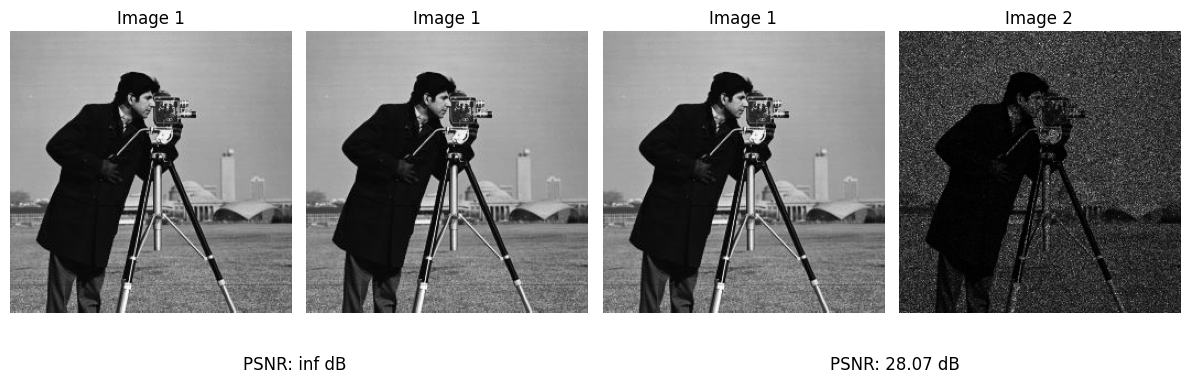

In [31]:
# Load images
image1 = cv2.imread("data/cameraman.png", cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread("data/cameraman_6.png", cv2.IMREAD_GRAYSCALE)

# Calculate PSNR values
psnr1 = PSNR(image1, image1)  
psnr2 = PSNR(image1, image2)  

fig, axes = plt.subplots(1, 4, figsize=(12, 4))

axes[0].imshow(image1, cmap='gray')
axes[0].set_title("Image 1")
axes[0].axis('off')

axes[1].imshow(image1, cmap='gray')
axes[1].set_title("Image 1")
axes[1].axis('off')

fig.text(0.25, 0.02, f"PSNR: {psnr1:.2f} dB", ha='center', va='center', fontsize=12)

axes[2].imshow(image1, cmap='gray')
axes[2].set_title("Image 1")
axes[2].axis('off')

axes[3].imshow(image2, cmap='gray')
axes[3].set_title("Image 2")
axes[3].axis('off')

fig.text(0.75, 0.02, f"PSNR: {psnr2:.2f} dB", ha='center', va='center', fontsize=12)
plt.subplots_adjust(wspace=0.1)  

# Display the plot
plt.tight_layout()
plt.show()

### Model 

In [ ]:
...